In [6279]:
# imports
# ref: https://www.kaggle.com/nandalald/android-app-recommendation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
import pandas as pd
import numpy as np
import gradio as gr
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn')


In [6280]:

file_name = "data/googleplaystore.csv"
df_temp = pd.read_csv(file_name, encoding="utf-8")


In [6281]:
df_temp.sample(5)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
6602,Wireless BP,MEDICAL,1.8,30,887k,500+,Free,0,Everyone,Medical,"May 27, 2016",1.1,4.3 and up
8770,Dr. Rocket,GAME,4.0,42182,3.4M,"1,000,000+",Free,0,Everyone,Arcade,"January 6, 2018",1.11,4.1 and up
3735,BBC Persian | BBC Farsi News,NEWS_AND_MAGAZINES,4.3,978,2.9M,"100,000+",Free,0,Everyone,News & Magazines,"May 12, 2018",1.8.2,4.0.3 and up
8003,CW Studio ®,COMMUNICATION,3.8,9,780k,100+,Paid,$0.99,Everyone,Communication,"May 19, 2015",1.2,2.3.3 and up
3747,"Vietnam Today - Read online newspapers, the ho...",NEWS_AND_MAGAZINES,4.2,21147,9.0M,"5,000,000+",Free,0,Teen,News & Magazines,"August 6, 2018",2.2.1,4.0.3 and up


In [6282]:
# เข้าใจข้อมูล
# check dataset info
df_temp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [6283]:
# check null
df_temp.isna().sum()
# จะเห็นได้ว่า rating มีข้อมูลเสียเยอะ


App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [6284]:
# data prep & data cleaning
# เราจะใช้ข้อมูลที่จำเป็นสำหรับการใช้ข้อมูลนี้เท่านั้น
# ข้อมูลที่ไม่จำเป็นเราจะนำออกไป เช่น rating, reviews บลาๆ

df = df_temp.copy()

# remove unuse cols
df = df.reindex(columns=['App', 'Category', 'Size',
                'Type', 'Genres', 'Price', 'Installs', 'Content Rating'])


In [6285]:
# rename col
temp_keys = {}
for i in df.columns:
    temp_keys[i] = i.lower()
df = df.rename(columns=temp_keys)


In [6286]:
df.isna().sum()
# ข้อมูลที่เสียมีน้อยมาก


app               0
category          0
size              0
type              1
genres            0
price             0
installs          0
content rating    1
dtype: int64

In [6287]:
# เราจะทำการลบข้อมูล ที่เสียหาย
df.dropna(axis=0, inplace=True)
df.isna().sum()


app               0
category          0
size              0
type              0
genres            0
price             0
installs          0
content rating    0
dtype: int64

In [6288]:
# แสดงข้อมูลเบื้องต้น
df.sample(10)


,app,category,size,type,genres,price,installs,content rating
5340,Al Quran MP3 - Quran Reading®,FAMILY,22M,Free,Education,0,"1,000,000+",Everyone
10419,Fast Motorcycle Driver 2016,GAME,49M,Free,Racing,0,"1,000,000+",Everyone 10+
4371,M Theme - Dark Green Icon Pack,PERSONALIZATION,4.9M,Free,Personalization,0,"10,000+",Everyone
10307,FD VR - Virtual Photo Gallery,FAMILY,7.4M,Free,Entertainment,0,"10,000+",Everyone
2446,Diabetes Testing,MEDICAL,3.6M,Free,Medical,0,500+,Mature 17+
5874,AZ Camera - Manual Pro Cam,PHOTOGRAPHY,1.6M,Free,Photography,0,"100,000+",Everyone
5294,RULES OF SURVIVAL,GAME,56M,Free,Action,0,"10,000,000+",Teen
2932,Pixlr – Free Photo Editor,PHOTOGRAPHY,31M,Free,Photography,0,"50,000,000+",Everyone
6266,BI News,NEWS_AND_MAGAZINES,25M,Free,News & Magazines,0,"1,000+",Everyone
911,Investigation Discovery GO,ENTERTAINMENT,13M,Free,Entertainment,0,"1,000,000+",Teen


In [6289]:
# เช็คข้อมูล insight หลักๆ ที่อาจจะทำให้เรามีปัญหาในการใช้ข้อมูล
df.groupby(['category'])['category'].count()


category
ART_AND_DESIGN           65
AUTO_AND_VEHICLES        85
BEAUTY                   53
BOOKS_AND_REFERENCE     231
BUSINESS                460
COMICS                   60
COMMUNICATION           387
DATING                  234
EDUCATION               156
ENTERTAINMENT           149
EVENTS                   64
FAMILY                 1971
FINANCE                 366
FOOD_AND_DRINK          127
GAME                   1144
HEALTH_AND_FITNESS      341
HOUSE_AND_HOME           88
LIBRARIES_AND_DEMO       85
LIFESTYLE               382
MAPS_AND_NAVIGATION     137
MEDICAL                 463
NEWS_AND_MAGAZINES      283
PARENTING                60
PERSONALIZATION         392
PHOTOGRAPHY             335
PRODUCTIVITY            424
SHOPPING                260
SOCIAL                  295
SPORTS                  384
TOOLS                   843
TRAVEL_AND_LOCAL        258
VIDEO_PLAYERS           175
WEATHER                  82
Name: category, dtype: int64

In [6290]:
# จะเห็นได้ว่า 1.9 นั้นไม่รู้คือ type อะไร
# และ genres, price,size installs นั้นสลับกันหมดเลย
# เรามาลองแก้กันดีกว่า
df.loc[df['category'] == '1.9']


,app,category,size,type,genres,price,installs,content rating


In [6291]:
# ข้อมูลที่เราพบปัญหานั้น col ไม่ครบ เราเลยจะนำข้อมูลจากตารางหลักมา
# ข้อมูลจากตารางหลักบางอย่างนั้นไม่มี เช่น Category, Gengre
# ซึ่งจากที่ดูๆ ข้อมูลเหมาะกับ HOUSE_AND_HOME, House & Home
# เราเลยจะเปลี่ยนข้อมูลให้กับข้อมูลนี้
temp_data = df_temp.loc[df_temp['App'] ==
                        'Life Made WI-Fi Touchscreen Photo Frame']
temp_data


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [6292]:
df.loc[df['app'] == 'Life Made WI-Fi Touchscreen Photo Frame',
       'type'] = temp_data['Price']
df.loc[df['app'] == 'Life Made WI-Fi Touchscreen Photo Frame',
       'size'] = temp_data['Category']
df.loc[df['app'] == 'Life Made WI-Fi Touchscreen Photo Frame',
       'price'] = temp_data['Installs']
df.loc[df['app'] == 'Life Made WI-Fi Touchscreen Photo Frame',
       'installs'] = temp_data['Size']
df.loc[df['app'] == 'Life Made WI-Fi Touchscreen Photo Frame',
       'category'] = 'HOUSE_AND_HOME'
df.loc[df['app'] == 'Life Made WI-Fi Touchscreen Photo Frame',
       'genres'] = 'House & Home'

# เพื่อความแน่ใจ ลองเช็คข้อมูลอีกรอบ
df.loc[df['app'] == 'Life Made WI-Fi Touchscreen Photo Frame']

# ข้อมูลได้ถูกเปลี่ยนแล้วเย้


,app,category,size,type,genres,price,installs,content rating


In [6293]:
# มาดูส่วนของ genres
df['genres'].head(5)

# จะเป็นได้ว่าบาง genres มีมา่กกว่า 1 รูปแบบ ซึ่งแบ่งด้วย ตัว semi colon


0                 Art & Design
1    Art & Design;Pretend Play
2                 Art & Design
3                 Art & Design
4      Art & Design;Creativity
Name: genres, dtype: object

In [6294]:
# เราจะแบ่งตัว genres ให้เป็นรูปแบบ ว่าตัว genres มันมีเท่าไหร่
genres = df['genres']
results = {}
for gen in genres:
    for g in gen.split(';'):
        if g not in results:
            results[g] = 1
            continue
        results[g] += 1
results


{'Art & Design': 69,
 'Pretend Play': 90,
 'Creativity': 37,
 'Action & Adventure': 138,
 'Auto & Vehicles': 85,
 'Beauty': 53,
 'Books & Reference': 234,
 'Business': 460,
 'Comics': 60,
 'Communication': 388,
 'Dating': 234,
 'Education': 761,
 'Music & Video': 47,
 'Brain Games': 70,
 'Entertainment': 667,
 'Events': 64,
 'Finance': 366,
 'Food & Drink': 127,
 'Health & Fitness': 343,
 'House & Home': 88,
 'Libraries & Demo': 85,
 'Lifestyle': 383,
 'Adventure': 91,
 'Arcade': 237,
 'Casual': 270,
 'Card': 51,
 'Action': 382,
 'Strategy': 110,
 'Puzzle': 167,
 'Sports': 402,
 'Music': 25,
 'Word': 29,
 'Racing': 119,
 'Simulation': 218,
 'Board': 63,
 'Trivia': 39,
 'Role Playing': 123,
 'Educational': 112,
 'Music & Audio': 1,
 'Video Players & Editors': 178,
 'Medical': 463,
 'Social': 295,
 'Shopping': 260,
 'Photography': 335,
 'Travel & Local': 258,
 'Tools': 843,
 'Personalization': 392,
 'Productivity': 424,
 'Parenting': 60,
 'Weather': 82,
 'News & Magazines': 283,
 'Maps &

In [6295]:
def convert_size(s):
    if s.replace('M', '').replace('.', '', 1).isdigit():
        size = float(s.replace('M', ''))
        return 1024 * size
    if s.replace('k', '').replace('.', '', 1).isdigit():
        return float(s.replace('k', ''))
    return 0


In [6296]:
# จะเห็นได้ว่า size เป็น type object ต้องเปลี่ยนเป็น int
# ซึ่งเราจะแปลกตัวเลขนี้ ให้เป็นค่า kb ทั้งหมด จะได้ใช้ได้ง่าย เมื่อมีค่าอิน นอกจากตัวค่า mb
# df['size'] = df['size'].str.replace('+', '', regex=True).replace(',', '', regex=True).astype(int)
df['size'] = df['size'].apply(convert_size)
df['size'].sample(5)


4929     2355.2
8858    22528.0
7526     6963.2
3543     4300.8
591     21504.0
Name: size, dtype: float64

In [6297]:
# จะเห็นได้ว่า installs เป็น type object ต้องเปลี่ยนเป็น int

df['installs'].sample(2)


6321       10,000+
6666    5,000,000+
Name: installs, dtype: object

In [6298]:
# ข้อมูลจะมี + ตามหลัง และ comma เราจะนำออก; และเปลี่ยนค่าเป็น int32
df['installs'] = df['installs'].str.replace(
    '+', '', regex=True).replace(',', '', regex=True).astype(int)
df['installs']


0           10000
1          500000
2         5000000
3        50000000
4          100000
           ...   
10836        5000
10837         100
10838        1000
10839        1000
10840    10000000
Name: installs, Length: 10839, dtype: int32

In [6299]:
# price จะมีสองรูปแบบคือ free กับ paid ต้องเปลี่ยนเป็น bin ถึงจะได้ง่ายต่อการทำงาน

df.loc[df['price'] != "Free", 'price'] = df.loc[df['price']
                                                != "Free", 'price'].apply(lambda x: x.replace('$', ''))

df.loc[df['price'] == 'Free', 'price'] = 0

df['price'].sample(5)


1162    0
4843    0
5253    0
7742    0
4746    0
Name: price, dtype: object

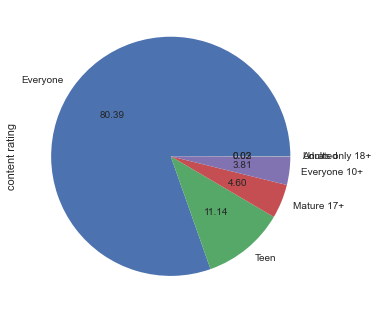

In [6300]:
# EDA
df['content rating'].value_counts().plot(kind='pie', autopct="%.2f")
plt.show()


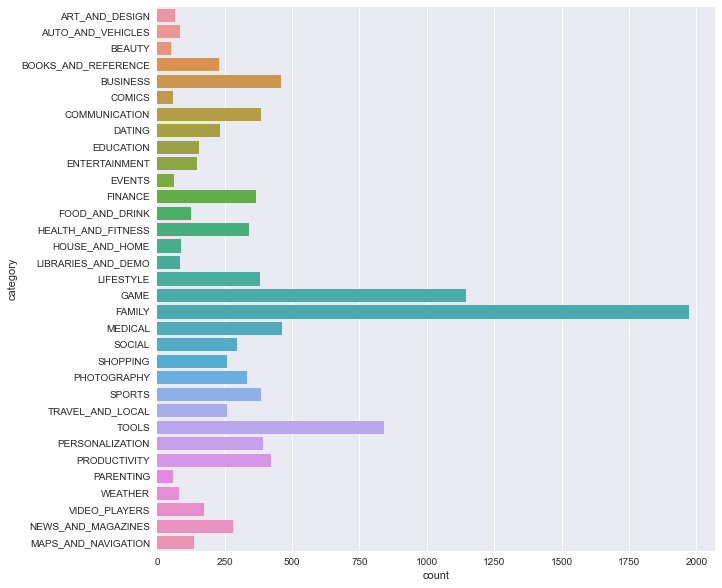

In [6301]:
plt.figure(figsize=(10, 10))
sns.countplot(y=df['category'])
plt.show()


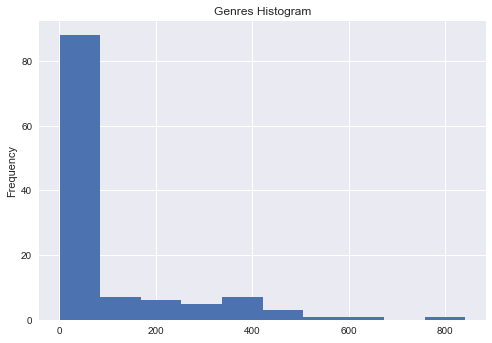

In [6302]:
df['genres'].value_counts().plot(kind='hist')
plt.title("Genres Histogram")
plt.show()


In [6303]:
# Feature Engineer

df.drop_duplicates(subset=['app'], inplace=True)


In [6304]:
data = df.copy()

describe = (data['genres'].replace(to_replace='(;|&| +)',
            value=' ', regex=True) + " " + data['category'] + " " + data['type'])
data['describe'] = describe

data.head()


,app,category,size,type,genres,price,installs,content rating,describe
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,19456.0,Free,Art & Design,0,10000,Everyone,Art Design ART_AND_DESIGN Free
1,Coloring book moana,ART_AND_DESIGN,14336.0,Free,Art & Design;Pretend Play,0,500000,Everyone,Art Design Pretend Play ART_AND_DESIGN Free
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,8908.8,Free,Art & Design,0,5000000,Everyone,Art Design ART_AND_DESIGN Free
3,Sketch - Draw & Paint,ART_AND_DESIGN,25600.0,Free,Art & Design,0,50000000,Teen,Art Design ART_AND_DESIGN Free
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,2867.2,Free,Art & Design;Creativity,0,100000,Everyone,Art Design Creativity ART_AND_DESIGN Free


In [6305]:
data.reset_index(drop=True, inplace=True)


In [6306]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(data['describe'])
count_matrix.shape

(9658, 81)

In [6307]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)


In [6308]:
def get_recommendations(app, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the app
    metadata = df.reset_index()
    indices = pd.Series(metadata.index, index=metadata['app'])
    idx = indices[app]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    _indices = [i[0] for i in sim_scores]
    recs = df[['app', 'genres', 'category', 'type']].iloc[_indices]
    recs['match_score'] = [i[1] for i in sim_scores]  # column match score
    recs['match_score'] = recs['match_score'].apply(lambda x: round(x, 4))
    return recs


def get_app_detail(app):
    return df.loc[df.app == app, ['app', 'genres', 'category', 'type']]


In [6309]:
get_app_detail('Dr. Rocket')

,app,genres,category,type
5227,Jamaa Amino for Animal Jam,Social,SOCIAL,Free


In [6310]:

get_recommendations('Dr. Rocket', cosine_sim).head(10)


,app,genres,category,type,match_score
2545,Instagram,Social,SOCIAL,Free,1.0
2546,Facebook Lite,Social,SOCIAL,Free,1.0
2547,"Messages, Text and Video Chat for Messenger",Social,SOCIAL,Free,1.0
2548,Tumblr,Social,SOCIAL,Free,1.0
2549,All Social Networks,Social,SOCIAL,Free,1.0
2550,Snapchat,Social,SOCIAL,Free,1.0
2551,Social network all in one 2018,Social,SOCIAL,Free,1.0
2552,Pinterest,Social,SOCIAL,Free,1.0
2553,TextNow - free text + calls,Social,SOCIAL,Free,1.0
2554,Google+,Social,SOCIAL,Free,1.0


In [6311]:

# iface = gr.Interface(get_recommendations, inputs=[gr.inputs.Textbox(label='App Name', default="Santa Fe App")], outputs=[
#                      gr.outputs.Dataframe(label='Your App'), gr.outputs.Dataframe(label='Similar App')])
# iface.launch(debug=True)
